In [1]:
#!/bin/env python

from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchmetrics import MeanAbsoluteError
from torchmetrics import MeanAbsolutePercentageError
from torchmetrics import MeanSquaredError
from torch_geometric.nn import GATConv,GATv2Conv,TransformerConv
from torch_geometric.data import Data,Batch
from tqdm import tqdm
from time import time
import os
from utils_graphgru import *
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.profiler import profile, record_function, ProfilerActivity

# torch.autograd.set_detect_anomaly(True)


# torch.set_default_tensor_type(torch.DoubleTensor)
# set to float32
# torch.set_default_dtype(torch.float32)
# torch.set_default_device()
# torch.set_default_tensor_type(torch.FloatTensor)
torch.set_default_dtype(torch.float32)
# torch.set_default_device('cpu')  # or 'cuda' if you're using a GPU
# torch.set

#######################################################
class GRULinear(nn.Module):
    def __init__(self, num_gru_units: int, output_dim: int,num_nodes: int, feature_num: int, bias: float = 0.0):
        super(GRULinear, self).__init__()
        self._num_gru_units = num_gru_units
        self._output_dim = output_dim
        self._bias_init_value = bias
        self.feature_num = feature_num
        self.weights = nn.Parameter(
            # torch.DoubleTensor(self._num_gru_units + self.feature_num, self._output_dim)
            torch.FloatTensor(self._num_gru_units + self.feature_num, self._output_dim)
        )
        self.biases = nn.Parameter(torch.FloatTensor(self._output_dim))
        self.reset_parameters()
        self.num_nodes = num_nodes

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weights)
        nn.init.constant_(self.biases, self._bias_init_value)

    def forward(self, inputs, hidden_state):
        batch_size = hidden_state.shape[0]
        # assert batch_size == 200
        inputs = inputs.reshape((batch_size, self.num_nodes, self.feature_num))
        # inputs (batch_size, num_nodes, feature_num)
        # hidden_state (batch_size, num_nodes, num_gru_units)
        hidden_state = hidden_state.reshape(
            (batch_size, self.num_nodes, self._num_gru_units)
        )
        # [inputs, hidden_state] "[x, h]" (batch_size, num_nodes, num_gru_units + 1)
        concatenation = torch.cat((inputs, hidden_state), dim=2)
        # [x, h] (batch_size * num_nodes, gru_units + 1)
        concatenation = concatenation.reshape((-1, self._num_gru_units + self.feature_num))
        # [x, h]W + b (batch_size * num_nodes, output_dim)
        outputs = concatenation @ self.weights + self.biases
        # [x, h]W + b (batch_size, num_nodes, output_dim)
        outputs = outputs.reshape((batch_size, self.num_nodes, self._output_dim))
        # [x, h]W + b (batch_size, num_nodes * output_dim)
        #outputs = outputs.reshape((batch_size, num_nodes * self._output_dim))
        return outputs

    def hyperparameters(self):
        return {
            "num_gru_units": self._num_gru_units,
            "output_dim": self._output_dim,
            "bias_init_value": self._bias_init_value,
        }

class GraphGRUCell(nn.Module):
    def __init__(self, num_units, num_nodes, r1,r2, batch_size,device, input_dim=1):
        super(GraphGRUCell, self).__init__()
        self.num_units = num_units
        self.num_nodes = num_nodes
        self.input_dim = input_dim
        self.batch_size = batch_size
        self.device = device
        self.act = torch.tanh
        self.init_params()
        self.r1 = r1
        self.r2 = r2
        self.GRU1 = GRULinear(self.num_units, 2 * self.num_units, self.num_nodes,self.input_dim)
        self.GRU2 = GRULinear(self.num_units, self.num_units, self.num_nodes,self.input_dim)
        # self.GCN3 = GATConv(101, 100)
        # Precompute edge_index_expanded
        self.edge_index_expanded = self.precompute_edge_index(self.batch_size)

        self.head = 2
        self.multiGAT = True
        self.dropout = 0.2
        self.OriginalGAT = True
        # self.GCN3 = GATConv(self.num_units+self.input_dim, self.num_units)
        if self.OriginalGAT:
            self.GCN3 = GATConv(self.num_units+self.input_dim, self.num_units,heads=self.head,concat=False)
            self.GCN4 = GATConv(self.num_units,self.num_units,concat=False)
        else:
            # self.GAT3 = GATv2Conv(self.num_units+self.input_dim, self.num_units,heads=self.head,concat=False)
            # self.GAT4 = GATv2Conv(self.num_units*self.head,self.num_units,concat=False)

            self.GAT3 = TransformerConv(self.num_units+self.input_dim, self.num_units,heads=self.head,concat=False)
            self.GAT4 = TransformerConv(self.num_units,self.num_units,concat=False)


    def init_params(self, bias_start=0.0):
        input_size = self.input_dim + self.num_units
        weight_0 = torch.nn.Parameter(torch.empty((input_size, 2 * self.num_units), device=self.device))
        bias_0 = torch.nn.Parameter(torch.empty(2 * self.num_units, device=self.device))
        weight_1 = torch.nn.Parameter(torch.empty((input_size, self.num_units), device=self.device))
        bias_1 = torch.nn.Parameter(torch.empty(self.num_units, device=self.device))

        torch.nn.init.xavier_normal_(weight_0)
        torch.nn.init.xavier_normal_(weight_1)
        torch.nn.init.constant_(bias_0, bias_start)
        torch.nn.init.constant_(bias_1, bias_start)

        self.register_parameter(name='weights_0', param=weight_0)
        self.register_parameter(name='weights_1', param=weight_1)
        self.register_parameter(name='bias_0', param=bias_0)
        self.register_parameter(name='bias_1', param=bias_1)

        self.weigts = {weight_0.shape: weight_0, weight_1.shape: weight_1}
        self.biases = {bias_0.shape: bias_0, bias_1.shape: bias_1}

    def precompute_edge_index(self, batch_size=None):
        edge_index = torch.tensor(np.stack((np.array(self.r1),np.array(self.r2))), dtype=torch.long).to(self.device)
        # Ensure edge_index is on the GPU
        edge_index = edge_index.to(self.device)
        
        # Replicate edge_index for each graph in the batch
        edge_index_expanded = edge_index.repeat(1, batch_size)
        
        # Create edge_index_offsets directly on the GPU
        edge_index_offsets = torch.arange(batch_size, device=self.device).repeat_interleave(edge_index.size(1)) * self.num_nodes
        
        # Add the offsets to edge_index_expanded
        edge_index_expanded += edge_index_offsets
        
        return edge_index_expanded        

    def forward(self, inputs, state):
        # inputs (batch_size, num_nodes * input_dim)
        # state (batch_size, num_nodes * gru_units) or (batch_size, num_nodes* num_units)
        batch_size = state.shape[0]
        # import pdb;pdb.set_trace()
        # update state using graph neighbors
        state=self._gc3(state,inputs, self.num_units) # (batch_size, self.num_nodes * self.gru_units)
        output_size = 2 * self.num_units
        value = torch.sigmoid(
            self.GRU1(inputs, state))  # (batch_size, self.num_nodes, output_size)
        r, u = torch.split(tensor=value, split_size_or_sections=self.num_units, dim=-1) # (batch_size, self.num_nodes, self.gru_units)
        r = torch.reshape(r, (-1, self.num_nodes * self.num_units))  # (batch_size, self.num_nodes * self.gru_units)
        u = torch.reshape(u, (-1, self.num_nodes * self.num_units))
        c = self.act(self.GRU2(inputs, r * state))
        c = c.reshape(shape=(-1, self.num_nodes * self.num_units))
        new_state = u * state + (1.0 - u) * c
        return new_state




    def _gc3(self, state, inputs, output_size, bias_start=0.0):

        batch_size = state.shape[0]
        # assert batch_size == 200
        # import pdb;pdb.set_trace()

        state = torch.reshape(state, (batch_size, self.num_nodes, -1))  # (batch, self.num_nodes, self.gru_units)
        inputs = torch.reshape(inputs, (batch_size, self.num_nodes, -1)) # (batch, self.num_nodes, self.input_dim)
        inputs_and_state = torch.cat([state, inputs], dim=2)
        input_size = inputs_and_state.shape[2]
        x = inputs_and_state.to(self.device)
        # edge_index = torch.tensor([self.r1, self.r2], dtype=torch.long).to(self.device)
        # import pdb;pdb.set_trace()
        
        # import pdb;pdb.set_trace()
        # b=[]
        # for i in x:
        #   x111=Data(x=i,edge_index=edge_index)
        #   xx=self.GCN3(x111.x,x111.edge_index)
        #   b.append(xx)
        # x1=torch.stack(b)

        # Assuming x is a list of node feature tensors and edge_index is shared
        # Create a list of Data objects
        # edge_index = torch.tensor([self.r1, self.r2], dtype=torch.long).to(self.device)
        # data_list = [Data(x=feat, edge_index=edge_index) for feat in x]

        # Use Batch to process all Data objects at once
        # batch1 = Batch.from_data_list(data_list)
        # Now pass the batched graph to your model
        # batch_output1 = self.GCN3(batch1.x, batch1.edge_index)

        # Flatten the input tensor and create a large batch of node features
        batch_size, num_nodes, num_features = x.size()
        x_flat = x.view(-1, num_features)  # Shape: (batch_size * num_nodes, num_features)

        # # Replicate edge_index for each graph in the batch
        # edge_index_expanded = edge_index.repeat(1, batch_size)
        # edge_index_offsets = torch.arange(batch_size).repeat_interleave(edge_index.size(1)) * num_nodes
        # edge_index_expanded += edge_index_offsets.to(self.device)

        # Create a single Data object and then batch it
        if batch_size == self.batch_size:
            edge_index = self.edge_index_expanded
        else:
            # last batch may have fewer samples
            edge_index = self.precompute_edge_index(batch_size)
        data = Data(x=x_flat, edge_index=edge_index)
        batch = Batch.from_data_list([data])
        # import pdb;pdb.set_trace()
        # Pass the batched graph to the model
        if self.OriginalGAT:
            if self.multiGAT:
                x = self.GCN3(batch.x, batch.edge_index)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout)
                x = self.GCN4(x, batch.edge_index)
                x = F.relu(x)
            else:
                x = self.GCN3(batch.x, batch.edge_index)
        else:
            if self.multiGAT:
                x = self.GAT3(batch.x, batch.edge_index)
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout)
                x = self.GAT4(x, batch.edge_index)
                x = F.relu(x)
            else:
                x = self.GAT3(batch.x, batch.edge_index)

        # biases = self.biases[(output_size,)]
        # x += biases
        x = x.reshape(shape=(batch_size, self.num_nodes* output_size))
        # import pdb;pdb.set_trace()
        return x


class GraphGRU(nn.Module):
    def __init__(self,future, input_size, hidden_size, output_dim,history,num_nodes,r1,r2,batch_size=128):
        super(GraphGRU, self).__init__()
        self.num_nodes = num_nodes
        self.input_dim =input_size
        self.output_dim = output_dim
        self.gru_units = hidden_size
        self.r1 = r1
        self.r2 = r2
        self.batch_size = batch_size
        self.input_window = history
        self.output_window = future
        self.device = torch.device('cuda')
        # add a cpu device for testing
        if not torch.cuda.is_available():
            self.device = torch.device('cpu')

        # -------------------构造模型-----------------------------
        self.GraphGRU_model = GraphGRUCell(self.gru_units, self.num_nodes, self.r1, self.r2, self.batch_size, self.device, self.input_dim)
        self.GraphGRU_model1 = GraphGRUCell(self.gru_units, self.num_nodes, self.r1,self.r2, self.batch_size, self.device, self.input_dim)
        self.fc1 = nn.Linear(self.gru_units*2, 120)
        #self.output_model = nn.Linear(self.gru_units*2, self.output_window * self.output_dim)
        self.output_model = nn.Linear(120, self.output_window * self.output_dim)
    def forward(self, x):
        """
        Args:
            batch: a batch of input,
                batch['X']: shape (batch_size, input_window, num_nodes, input_dim) \n
                batch['y']: shape (batch_size, output_window, num_nodes, output_dim) \n

        Returns:
            torch.tensor: (batch_size, self.output_window, self.num_nodes, self.output_dim)
        """
        inputs = x
        # labels = batch['y']

        batch_size, input_window, num_nodes, input_dim = inputs.shape
        # assert batch_size == 200
        inputs = inputs.permute(1, 0, 2, 3)  # (input_window, batch_size, num_nodes, input_dim)
        inputs = inputs.view(self.input_window, batch_size, num_nodes * input_dim).to(self.device) # (input_window, batch_size, num_nodes * input_dim)
        state = torch.zeros(batch_size, self.num_nodes * self.gru_units).to(self.device) # (batch_size, self.num_nodes * self.gru_units)
        state1 = torch.zeros(batch_size, self.num_nodes * self.gru_units).to(self.device)

        for t in range(input_window):
              state = self.GraphGRU_model(inputs[t], state) # (batch_size, self.num_nodes * self.gru_units)
              state1 = self.GraphGRU_model1(inputs[input_window-t-1], state1) # (batch_size, self.num_nodes * self.gru_units)


        state = state.view(batch_size, self.num_nodes, self.gru_units)  # (batch_size, self.num_nodes, self.gru_units)
        state1 = state1.view(batch_size, self.num_nodes, self.gru_units)  # (batch_size, self.num_nodes, self.gru_units)
        #output1 = self.output_model(state)  # (batch_size, self.num_nodes, self.output_window * self.output_dim)

        state2 = torch.cat([state, state1], dim=2) # (batch_size, self.num_nodes, self.gru_units*2)
        state2=self.fc1(state2) # (batch_size, self.num_nodes, 120)
        state2 = state2.relu()
        output2=self.output_model(state2)
        # state2 = state2.sigmoid()
        output2 = output2.sigmoid() # (batch_size, self.num_nodes, self.output_window * self.output_dim)
        
        output2 = output2.view(batch_size, self.num_nodes, self.output_window, self.output_dim)
        output2 = output2.permute(0, 2, 1, 3)

        return output2
    

         

def eval_model(mymodel,test_loader,model_prefix,history=90,future=60):
    mae = MeanAbsoluteError().cuda()
    mape=MeanAbsolutePercentageError().cuda()
    mse=MeanSquaredError().cuda()
    net = mymodel.eval().cuda()
    mse_list = []
    mae_list = []
    mape_list = []
    with torch.no_grad():
        for i,(batch_x, batch_y) in enumerate (test_loader):
            assert i == 0 # batch size is equal to the test set size
            batch_x=batch_x.cuda()
            batch_y=batch_y.cuda()
            outputs = net(batch_x)
            outputs,batch_y = mask_outputs_batch_y(outputs, batch_y)
            # batch_y = batch_y[:,:,:,2:3]
            for u in range(future):
                MAE_d=mae(outputs[:,u,:,:],batch_y[:,u,:,:]).cpu().detach().numpy()
                MAPE_d=mape(outputs[:,u,:,:],batch_y[:,u,:,:]).cpu().detach().numpy()
                # MSE_d=mse(outputs[:,u,:,:],batch_y[:,u,:,:]).cpu().detach().numpy()
                MSE_d = mse(outputs[:, u, :, :].contiguous(), batch_y[:, u, :, :].contiguous()).cpu().detach().numpy()
                print("TIME:%d ,MAE:%1.5f,  MAPE: %1.5f, MSE: %1.5f" % ((u+1),MAE_d, MAPE_d,MSE_d))
                # import pdb;pdb.set_trace()
                if u==149:
                    for sample in range(0,batch_x.shape[0],100):
                        print('sample:',sample)
                        # print('output:',outputs[sample,u,:].view(30,8))
                        # print('label:',batch_y[sample,u,:].view(30,8))
                        print('output:',outputs[sample,u,134])
                        print('label:',batch_y[sample,u,134])
                        # import pdb;pdb.set_trace()
                mse_list.append(MSE_d.item())
                mae_list.append(MAE_d.item())
                mape_list.append(MAPE_d.item())
        print('MSE:',mse_list)
        print('MAE:',mae_list)
        # print('MAPE:',mape_list)
        # plot mse and mae
        plt.figure()
        plt.plot(mse_list)
        plt.plot(mae_list)
        # plt.plot(mape_list)
        plt.legend(['MSE', 'MAE'])
        plt.xlabel('Prediction Horizon/frame')
        plt.ylabel('Loss')
        plt.savefig(f'./data/fig/nm_graphgru_{model_prefix}_testingloss{history}_{future}.png') 



In [10]:
# def main():
with_train = False 
continue_train = False
last_val_loss = 0.0025
voxel_size = int(128)
num_nodes = 240
history,future= 90,270
# history,future=10,10
p_start = 1
p_end = 28
# p_end = 4
output_size = 1
num_epochs=5
batch_size=56
# batch_size=32 #G1 90
# batch_size=64 # 256 model
# batch_size=64*2 #150 64GB
# batch_size=25 #G2 T h2
# batch_size=32 #T1 h1 fulledge
hidden_dim = 100
model_prefix = f'num_G2_h2_lre42_fulledge_{hidden_dim}'
# model_prefix = f'cutloop150_num_G1_h1_lre42_fulledge_{hidden_dim}'
# model_prefix = f'G1_h1_lre43_90_10_fulledge_100'
# model_prefix = f'G1_h1_lre43_fulledge_100'
train_x,train_y,test_x,test_y,val_x,val_y = get_train_test_data_on_users_all_videos(history,future,p_start=p_start,p_end=p_end,voxel_size=voxel_size,num_nodes=num_nodes)
print('shape of train_x:',train_x.shape,'shape of train_y:',train_y.shape,
        'shape of test_x:',test_x.shape,'shape of test_y:',test_y.shape,
        'shape of val_x:',val_x.shape,'shape of val_y:',val_y.shape)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)
val_x = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)

train_dataset=torch.utils.data.TensorDataset(train_x,train_y)
test_dataset=torch.utils.data.TensorDataset(test_x,test_y)
val_dataset=torch.utils.data.TensorDataset(val_x,val_y)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True,num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                        batch_size=test_x.shape[0],
                                        shuffle=False)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                        batch_size=val_x.shape[0],
                                        shuffle=False)           
# load graph edges
voxel_size = int(256/2)
edge_prefix = str(voxel_size)
edge_path = f'./data/{edge_prefix}/graph_edges_integer_index.csv'
# r1, r2 = getedge('newedge',900)
r1, r2 = getedge(edge_path)
feature_num = train_x.shape[-1]
assert feature_num == 7
input_size = feature_num
mymodel = GraphGRU(future,input_size,hidden_dim,output_size,history,num_nodes,r1,r2,batch_size)
# if best model is saved, load it
best_checkpoint_model_path = f'./data/model/best_model_{model_prefix}_checkpoint{history}_{future}.pt' 
if os.path.exists(best_checkpoint_model_path):   
    mymodel.load_state_dict(torch.load(best_checkpoint_model_path))
    print(f'{best_checkpoint_model_path} model loaded')
if torch.cuda.is_available():
    mymodel=mymodel.cuda()
# print(mymodel)
if with_train:
    # learning_rate=0.0003
    learning_rate = 0.0003
    criterion = torch.nn.MSELoss()    # mean-squared error for regression
    # optimizer = torch.optim.Adam(mymodel.parameters(), lr=learning_rate,weight_decay=0.01)
    optimizer = torch.optim.Adam(mymodel.parameters(), lr=learning_rate)
    # optimizer = torch.optim.AdamW(mymodel.parameters(), lr=learning_rate)
    lossa=[]
    val_loss_list = []

    # Initialize the early stopping object
    if continue_train:
        early_stopping = EarlyStopping(patience=5, verbose=True, val_loss_min=last_val_loss, path=best_checkpoint_model_path) #continue training the best check point
    else:
        early_stopping = EarlyStopping(patience=5, verbose=True, val_loss_min=float('inf'), path=best_checkpoint_model_path)
    # learning rate scheduler 
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.1, min_lr=1e-6)

    for epochs in range(1,num_epochs+1):
        mymodel.train()
        iter1 = 0
        iter2 = 0
        loss_total=0
        # with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True, profile_memory=True) as prof:
            # with record_function("model_training"):
        for i,(batch_x, batch_y) in tqdm(enumerate (train_loader)):
            if torch.cuda.is_available():
                batch_x=batch_x.cuda()
                batch_y=batch_y.cuda() # (batch_size, self.output_window, self.num_nodes, self.output_dim)
            outputs = mymodel(batch_x) # (batch_size, self.output_window, self.num_nodes, self.output_dim)
            optimizer.zero_grad()
            # break

            # only get loss on the node who has points, in other words, the node whose occupancy is not 0
            # get the mask of the node whose occupancy is not 0, occupancy is the first feature in batch_y
            outputs,batch_y = mask_outputs_batch_y(outputs, batch_y)
            loss = criterion(outputs,batch_y)
            loss_total=loss_total+loss.item()
            #backpropagation
            loss.backward()
            optimizer.step()
            iter1+=1
            # print loss
            if i % 10 == 0:
                print("epoch:%d,  loss: %1.5f" % (epochs, loss.item()),flush=True)
        # Print profiler results
        # print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=30))  
        # break                          
            
        loss_avg = loss_total/iter1
        losss=loss_avg
        lossa.append(losss)
        print("epoch:%d,  loss: %1.5f" % (epochs, loss_avg),flush=True)
        # save model every 10 epochs and then reload it to continue training
        if epochs % 10 == 0:
            #save and reloasd
            torch.save(mymodel.state_dict(), f'./data/model/graphgru_{model_prefix}_{history}_{future}_{epochs}.pt')
            print('model saved')
        val_loss = get_val_loss(mymodel,val_loader,criterion)
        val_loss_list.append(val_loss)
        print("val_loss:%1.5f" % (val_loss))
        # Step the scheduler with the validation loss
        scheduler.step(val_loss)  
        # Log the last learning rate
        current_lr = optimizer.param_groups[0]['lr']
        print(f'Current learning rate: {current_lr}')    
        # Call early stopping
        early_stopping(val_loss, mymodel)
        if early_stopping.early_stop:
            print("Early stopping")
            break

    np.save(f'./data/output/graphgru_{model_prefix}_training_loss{history}_{future}',lossa)
    np.save(f'./data/output/graphgru_{model_prefix}_val_loss{history}_{future}',val_loss_list)
    print('loss saved')
    # plot training and val loss and save to file
    plt.figure()
    plt.plot(lossa)
    plt.plot(val_loss_list)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(f'./data/fig/graphgru_{model_prefix}_trainingloss{history}_{future}.png')

mymodel.load_state_dict(torch.load(best_checkpoint_model_path))



  # eval_model(mymodel,test_loader,model_prefix,history=history,future=future)




load data from file
shape of train_x: (6192, 90, 240, 7) shape of train_y: (6192, 270, 240, 7) shape of test_x: (589, 90, 240, 7) shape of test_y: (589, 270, 240, 7) shape of val_x: (2026, 90, 240, 7) shape of val_y: (2026, 270, 240, 7)
./data/model/best_model_num_G2_h2_lre42_fulledge_100_checkpoint90_270.pt model loaded


<All keys matched successfully>

In [11]:
def eval_model_sample(mymodel,test_loader,model_prefix,history=90,future=60):
    mae = MeanAbsoluteError().cuda()
    mape=MeanAbsolutePercentageError().cuda()
    mse=MeanSquaredError().cuda()
    net = mymodel.eval().cuda()
    mse_list = []
    mae_list = []
    mape_list = []
    label_y_list = []
    output_y_list = []
    with torch.no_grad():
        for i,(batch_x, batch_y) in enumerate (test_loader):
            # assert i == 0 # batch size is equal to the test set size
            batch_x=batch_x.cuda()
            batch_y=batch_y.cuda()
            sample = 0
            node_index = 134
            # node_index = 82
            num_sample_to_model = 100
            # print('output:',outputs[sample,0,:].view(30,8))
            
            batch_y = batch_y[sample:sample+num_sample_to_model,:,:,:]
            batch_x = batch_x[sample:sample+num_sample_to_model,:,:,:]
            # batch_y = batch_y.view(1,future,num_nodes,output_size)
            # batch_x = batch_x.view(1,history,num_nodes,input_size)
            # outputs = outputs[sample,:,:,:]
            outputs = net(batch_x)
            
            outputs,batch_y = mask_outputs_batch_y(outputs, batch_y)
            # for sample in range(0,batch_x.shape[0],100):
            # batch_y = batch_y[:,:,:,2:3]
            print('label:',batch_y[sample,0,:].view(40,6))
            # get one sample from the batch_y and outputs
            batch_y = batch_y[sample,:,:,:]
            outputs = outputs[sample,:,:,:]
            # keep the same shape as the original
            batch_y = batch_y.view(1,future,num_nodes,output_size)
            outputs = outputs.view(1,future,num_nodes,output_size)
            for u in range(future):
                MAE_d=mae(outputs[:,u,:,:],batch_y[:,u,:,:]).cpu().detach().numpy()
                MAPE_d=mape(outputs[:,u,:,:],batch_y[:,u,:,:]).cpu().detach().numpy()
                MSE_d = mse(outputs[:, u, :, :].contiguous(), batch_y[:, u, :, :].contiguous()).cpu().detach().numpy()
                label_y_list.append(batch_y[:,u,node_index,:].cpu().detach().numpy().reshape(1).item())
                output_y_list.append(outputs[:,u,node_index,:].cpu().detach().numpy().reshape(1).item())

                
                # print("TIME:%d ,MAE:%1.5f,  MAPE: %1.5f, MSE: %1.5f" % ((u+1),MAE_d, MAPE_d,MSE_d))
                # import pdb;pdb.set_trace()
                # if u==149:
                #     for sample in range(0,batch_x.shape[0],10000):
                #         print('sample:',sample)
                #         # print('output:',outputs[sample,u,:].view(30,8))
                #         # print('label:',batch_y[sample,u,:].view(30,8))
                #         print('output:',outputs[sample,u,134])
                #         print('label:',batch_y[sample,u,134])
                #         # import pdb;pdb.set_trace()
                mse_list.append(MSE_d.item())
                mae_list.append(MAE_d.item())
                mape_list.append(MAPE_d.item())
            # break
        print('MSE:',mse_list)
        print('MAE:',mae_list)

        print('label_y_list:',label_y_list)
        print('output_y_list:',output_y_list)
        # print('MAPE:',mape_list)
        # plot mse and mae
        plt.figure()
        plt.plot(mse_list)
        plt.plot(mae_list)
        # plt.plot(mape_list)
        plt.legend(['MSE', 'MAE'])
        plt.xlabel('Prediction Horizon/frame')
        plt.ylabel('Loss')
        plt.savefig(f'./data/fig/sample_nm_graphgru_{model_prefix}_testingloss{history}_{future}.png') 


        # plot the output and label
        plt.figure()
        plt.plot(label_y_list)
        plt.plot(output_y_list)
        plt.legend(['Label', 'Output'])
        plt.xlabel('Prediction Horizon/frame')
        plt.ylabel('occlusion')
        plt.savefig(f'./data/fig/sample_nm_graphgru_{model_prefix}_occlusion_output{history}_{future}.png')




label: tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0069, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.2469, 0.1221, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1043, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1728, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0617, 0.0041, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.1084, 0.0370, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1866, 0.1866, 0.0000, 0.0000],
        [0.0000, 0.0165, 0.8121, 0.0370, 0.0000, 0.0000],
        [0.0000, 0.2716, 0.4499, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0096, 0.4225, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.1962, 0.0000, 0.0000, 0.0000],
       

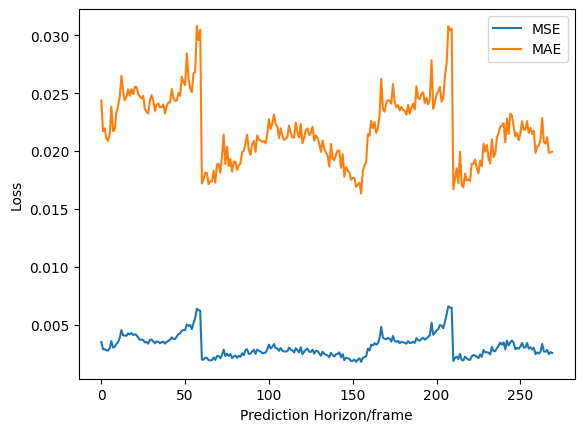

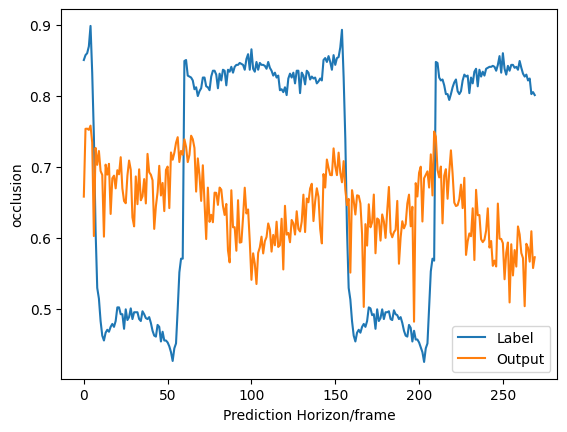

In [12]:
# train_loader
# change train_loader's batch size to test_loader's batch size
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=train_x.shape[0],
                                        shuffle=True,num_workers=4)

with torch.no_grad():
    eval_model_sample(mymodel,test_loader,model_prefix,history=history,future=future)
  

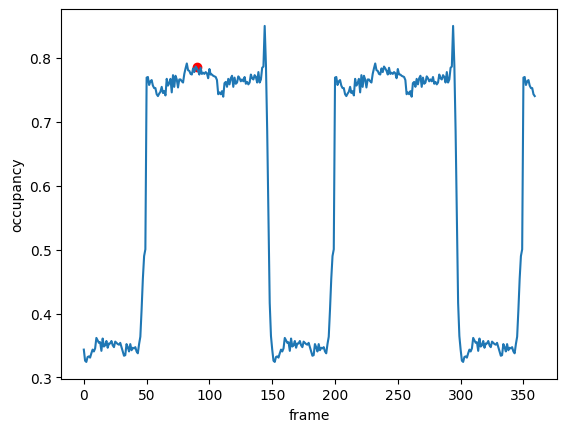

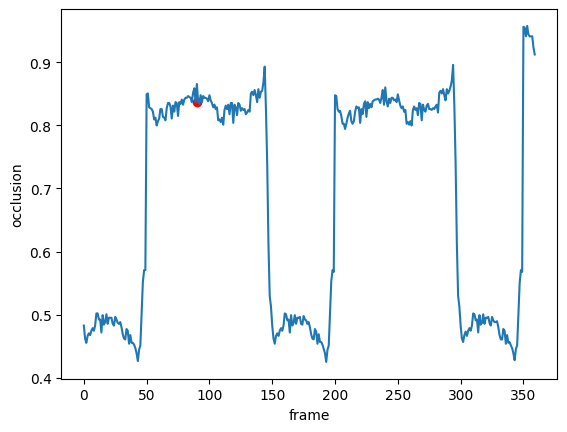

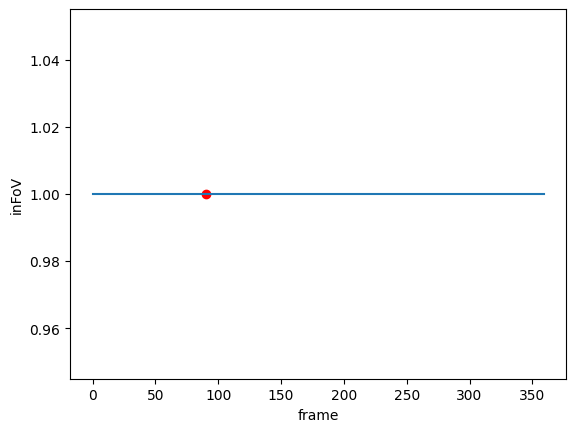

In [19]:
with torch.no_grad():
    for i,(batch_x, batch_y) in enumerate (test_loader):
        sample = 100
        node_index = 134
        batch_x_o=batch_x[sample,:,node_index,0]
        batch_x_o=batch_x_o.cpu().detach().numpy()
        batch_y_o=batch_y[sample,:,node_index,0]
        batch_y_o=batch_y_o.cpu().detach().numpy()
        # plot concatenate batch_x_o and batch_y_o but use different color for batch_x_o and batch_y_o
        all_o = np.concatenate((batch_x_o,batch_y_o),axis=0)
        # print('batch_x:',batch_x)
        plt.figure()
        plt.plot(all_o)
        # plot a dot at the end of batch_x_o and the start of batch_y_o
        plt.scatter(90,batch_x_o[-1],c='r')
        plt.xlabel('frame')
        plt.ylabel('occupancy')
        plt.savefig(f'./data/fig/sample_occupancy.png')

        # plot batch_x_occlusion and batch_y_occlusion
        batch_x_occlusion=batch_x[sample,:,node_index,2]
        batch_x_occlusion=batch_x_occlusion.cpu().detach().numpy()
        batch_y_occlusion=batch_y[sample,:,node_index,2]
        batch_y_occlusion=batch_y_occlusion.cpu().detach().numpy()
        all_occlusion = np.concatenate((batch_x_occlusion,batch_y_occlusion),axis=0)
        plt.figure()
        plt.plot(all_occlusion)
        plt.scatter(90,batch_x_occlusion[-1],c='r')
        plt.xlabel('frame')
        plt.ylabel('occlusion')
        plt.savefig(f'./data/fig/sample_occlusion.png')

        # plot batch_x_inFoV and batch_y_inFoV
        batch_x_inFoV=batch_x[sample,:,node_index,1]
        batch_x_inFoV=batch_x_inFoV.cpu().detach().numpy()
        batch_y_inFoV=batch_y[sample,:,node_index,1]
        batch_y_inFoV=batch_y_inFoV.cpu().detach().numpy()
        all_inFoV = np.concatenate((batch_x_inFoV,batch_y_inFoV),axis=0)
        plt.figure()
        plt.plot(all_inFoV)
        plt.scatter(90,batch_x_inFoV[-1],c='r')
        plt.xlabel('frame')
        plt.ylabel('inFoV')
        plt.savefig(f'./data/fig/sample_inFoV.png')
        
